In [1]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

This notebook was created using version 1.35.0 of the Azure ML SDK.
You are currently using version 1.41.0 of the Azure ML SDK.


In [2]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()

In [3]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-cluster-nc6"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=600,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [4]:
from azureml.core import Experiment

experiment_name = "wheres-wally-exp"
experiment = Experiment(ws, name=experiment_name)

In [5]:
print(os.getcwd())

c:\Users\ayoub\OneDrive\TMM\Stage fase 3\Arinti\FindWaldo\FindWaldo\streamlit


In [6]:
''' import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/fridgeObjects.zip"
data_file = "./fridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
    print("done")
# delete zip file
os.remove(data_file) '''

' import os\nimport urllib\nfrom zipfile import ZipFile\n\n# download data\ndownload_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/fridgeObjects.zip"\ndata_file = "./fridgeObjects.zip"\nurllib.request.urlretrieve(download_url, filename=data_file)\n\n# extract files\nwith ZipFile(data_file, "r") as zip:\n    print("extracting files...")\n    zip.extractall()\n    print("done")\n# delete zip file\nos.remove(data_file) '

c:\Users\ayoub\OneDrive\TMM\Stage fase 3\Arinti\FindWaldo\FindWaldo\streamlit


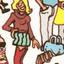

In [7]:
from IPython.display import Image
print(os.getcwd())
sample_image = "./images/wally/w1.jpg"
Image(filename=sample_image)

In [8]:
import json
import os

src = "./images/"
train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = {
    "image_url": "AmlDatastore://"
    + workspaceblobstore
    + "/"
    + os.path.basename(os.path.dirname(src)),
    "label": "",
}

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./images/nwally
Parsing ./images/Wally


In [9]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./images", target_path="images")

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 234 files
Target already exists. Skipping upload for images\changefilenames.py
Target already exists. Skipping upload for images\create.py
Target already exists. Skipping upload for images\trainwanno.jasonl
Target already exists. Skipping upload for images\trainwanno.txt
Target already exists. Skipping upload for images\train_annotations.jsonl
Target already exists. Skipping upload for images\validation_annotations.jsonl
Target already exists. Skipping upload for images\nwally\n1.jpg
Target already exists. Skipping upload for images\nwally\n10.jpg
Target already exists. Skipping upload for images\nwally\n100.jpg
Target already exists. Skipping upload for images\nwally\n101.jpg
Target already exists. Skipping upload for images\nwally\n102.jpg
Target already exists. Skipping upload for images\nwally\n103.jpg
Target already exists. Skipping upload for images\nwally\n104.jpg
Target already exists. Skipping upload for images\nwally\n105.jpg
Target already exists. S

$AZUREML_DATAREFERENCE_1797019892c442df80810542e705294f

In [10]:
from azureml.core import Dataset
from azureml.data import DataType

# get existing training dataset
training_dataset_name = "imagestraining"
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print("Found the training dataset", training_dataset_name)
else:
    # create training dataset
    training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("images/train_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    training_dataset = training_dataset.register(
        workspace=ws, name=training_dataset_name
    )
# get existing validation dataset
validation_dataset_name = "imagesvalidation"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print("Found the validation dataset", validation_dataset_name)
else:
    # create validation dataset
    validation_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("images/validation_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    validation_dataset = validation_dataset.register(
        workspace=ws, name=validation_dataset_name
    )
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Found the training dataset imagestraining
Found the validation dataset imagesvalidation
Training dataset name: imagestraining
Validation dataset name: imagesvalidation


In [11]:
training_dataset.to_pandas_dataframe()

,image_url,label
0,workspaceblobstore/images/Wally/13_6_3.jpg,Wally
1,workspaceblobstore/images/Wally/14_1_12.jpg,Wally
2,workspaceblobstore/images/Wally/16_10_4.jpg,Wally
3,workspaceblobstore/images/Wally/17_13_5.jpg,Wally
4,workspaceblobstore/images/Wally/18_15_7.jpg,Wally
...,...,...
177,workspaceblobstore/images/nwally/Schermafbeeld...,nwally
178,workspaceblobstore/images/nwally/Schermafbeeld...,nwally
179,workspaceblobstore/images/nwally/Schermafbeeld...,nwally
180,workspaceblobstore/images/nwally/Schermafbeeld...,nwally


In [12]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_vit = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("vitb16r224")}),
    iterations=1,
)

In [13]:
automl_image_run = experiment.submit(image_config_vit)


Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-wally-image-multiclass,AutoML_29c38490-c58d-4a70-b5e1-b7996e1d4803,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [14]:
automl_image_run.wait_for_completion(wait_post_processing=True)


{'runId': 'AutoML_29c38490-c58d-4a70-b5e1-b7996e1d4803',
 'target': 'gpu-cluster-nc6',
 'status': 'Completed',
 'startTimeUtc': '2022-05-03T11:55:01.76842Z',
 'endTimeUtc': '2022-05-03T12:03:58.134778Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-cluster-nc6',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-wally-image-multiclass","subscription_id":"a8260178-3b6d-4bce-a07e-3aae8c7a62af","resource_group":"RG-Internship-Ayoub","workspace_name":"Wally","region":"westeurope","compute_target":"gpu-cluster-nc6","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric"

In [15]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "learning_rate": uniform(0.001, 0.01),
    "model": choice(
        {
            "model_name": choice("vitb16r224", "vits16r224"),
            "number_of_epochs": choice(15, 30),
        },
        {
            "model_name": choice("seresnext", "resnest50"),
            "layers_to_freeze": choice(0, 2),
        },
    ),
}

tuning_settings = {
    "iterations": 10,
    "max_concurrent_iterations": 2,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [16]:
automl_image_run = experiment.submit(automl_image_config)


Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-wally-image-multiclass,AutoML_4de1264e-b45b-4798-86ce-4ce654b180c2,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
automl_image_run.wait_for_completion(wait_post_processing=True)


{'runId': 'AutoML_4de1264e-b45b-4798-86ce-4ce654b180c2',
 'target': 'gpu-cluster-nc6',
 'status': 'Completed',
 'startTimeUtc': '2022-05-03T12:04:19.319972Z',
 'endTimeUtc': '2022-05-03T12:40:55.776718Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-cluster-nc6',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-wally-image-multiclass","subscription_id":"a8260178-3b6d-4bce-a07e-3aae8c7a62af","resource_group":"RG-Internship-Ayoub","workspace_name":"Wally","region":"westeurope","compute_target":"gpu-cluster-nc6","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric

In [18]:
from azureml.core import Run

hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run


Experiment,Id,Type,Status,Details Page,Docs Page
automl-wally-image-multiclass,AutoML_4de1264e-b45b-4798-86ce-4ce654b180c2_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [19]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)

CHECKPOINT


In [20]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cpu-mc"
# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    # Provision AKS cluster with a CPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

Found existing compute target


In [21]:
from azureml.core.model import InferenceConfig

best_child_run.download_file(
    "outputs/scoring_file_v_1_0_0.py", output_file_path="score.py"
)
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="score.py", environment=environment)

In [22]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled=True, cpu_cores=1, memory_gb=5, enable_app_insights=True
)

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name="automl-image-test-cpu-mc",
    overwrite=True,
)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-05-03 14:41:11+02:00 Registering the environment.
2022-05-03 14:41:11+02:00 Use the existing image.
2022-05-03 14:41:13+02:00 Checking the status of deployment automl-image-test-cpu-mc..
2022-05-03 14:42:03+02:00 Checking the status of inference endpoint automl-image-test-cpu-mc.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


In [23]:

import os
k = os.getcwd()
print(k)

c:\Users\ayoub\OneDrive\TMM\Stage fase 3\Arinti\FindWaldo\FindWaldo\streamlit


In [48]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
k = os.getcwd()
print(k)
sample_image = "test7.png"

# Load image data
data = open(sample_image, "rb").read()

# Set the content type
headers = {"Content-Type": "application/octet-stream"}

# If authentication is enabled, set the authorization header
headers["Authorization"] = f"Bearer {key}"

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

c:\Users\ayoub\OneDrive\TMM\Stage fase 3\Arinti\FindWaldo\FindWaldo\streamlit
{"filename": "/tmp/tmpilz_4ht9", "probs": [0.9711996912956238, 0.02880030684173107], "labels": ["Wally", "nwally"]}



Wally (0.971)


<Figure size 1296x864 with 0 Axes>

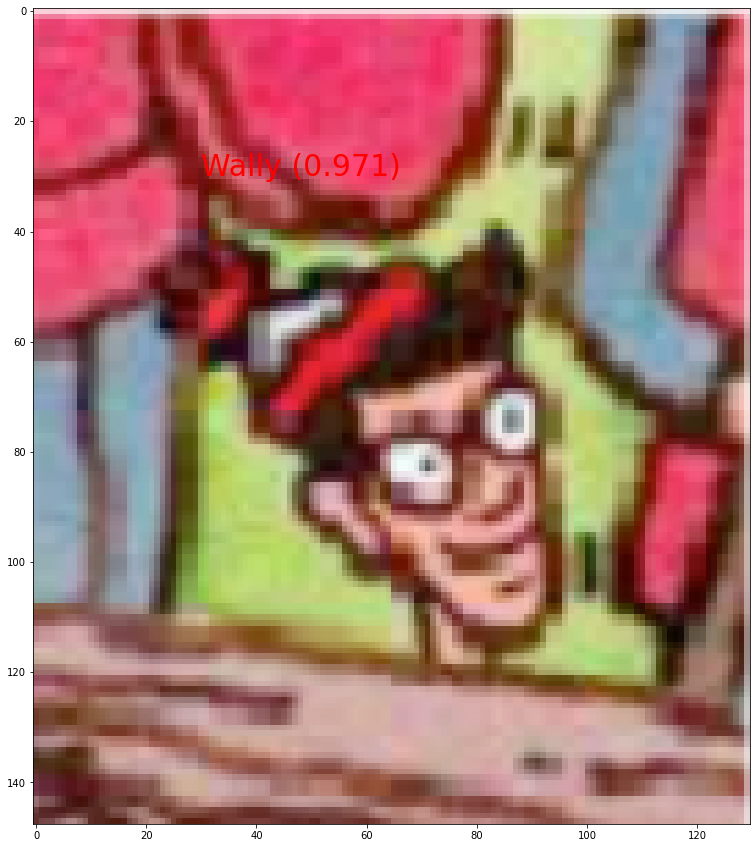

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)
plt.savefig('output.png')
plt.show()